# NLP Project

 Sources:
 - [Pyspellchecker]https://pyspellchecker.readthedocs.io/en/latest/
 - [GloVe Pretrained Vectors]https://nlp.stanford.edu/projects/glove/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from nltk.corpus import stopwords
from collections import Counter
from string import punctuation
import re
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ivayl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


## Data analysis

### Class distribution

[[Text(0, 0, 'Non-disater'), Text(1, 0, 'Disaster')]]

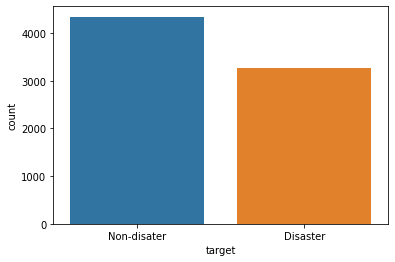

In [3]:
import warnings
warnings.filterwarnings('ignore')
res = seaborn.countplot(df['target'])
res.set(xticklabels=["Non-disater", "Disaster"])

There are less tweets about disasters than not. 

Text(0.5, 0.98, 'Average length of tweets')

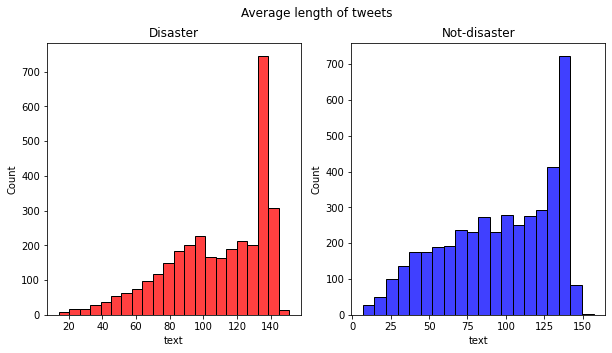

In [4]:
disaster_tweet_lengths = df[df['target'] == 1]['text'].str.len()
nondisaster_tweet_lengths = df[df['target'] == 0]['text'].str.len()

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

seaborn.histplot(disaster_tweet_lengths.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Disaster')

seaborn.histplot(nondisaster_tweet_lengths.map(lambda x: np.mean(x)), ax=ax2, color='blue')
ax2.set_title('Not-disaster')

figure.suptitle('Average length of tweets')

### Length of Tweets

Both classes have almost the same distribution, which doesn't help us with anything.

### Number of Words in Tweets

Text(0.5, 0.98, 'Average number of words in tweets')

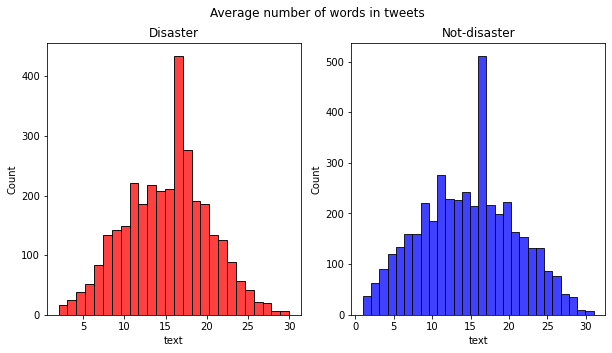

In [5]:
disaster_tweet_lengths = df[df['target'] == 1]['text'].str.split().map(len)
nondisaster_tweet_lengths = df[df['target'] == 0]['text'].str.split().map(len)

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

seaborn.histplot(disaster_tweet_lengths.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Disaster')

seaborn.histplot(nondisaster_tweet_lengths.map(lambda x: np.mean(x)), ax=ax2, color='blue')
ax2.set_title('Not-disaster')

figure.suptitle('Average number of words in tweets')

And again, both classes have almost the same distribution, which doesn't help us with anything.

Text(0.5, 0.98, 'Average word length in each tweet')

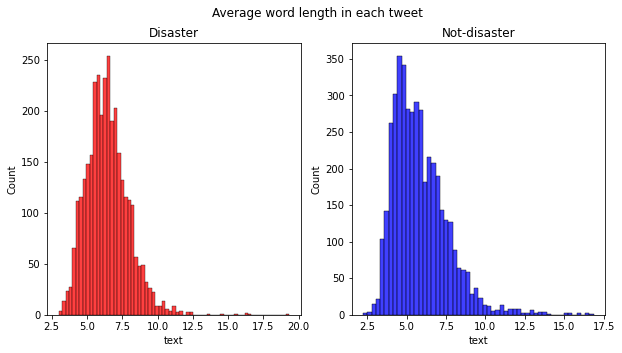

In [6]:
disaster_tweet_word_lengths = df[df['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
nondisaster_tweet_word_lengths = df[df['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

seaborn.histplot(disaster_tweet_word_lengths.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Disaster')

seaborn.histplot(nondisaster_tweet_word_lengths.map(lambda x: np.mean(x)), ax=ax2, color='blue')
ax2.set_title('Not-disaster')

figure.suptitle('Average word length in each tweet')

We can conclude that the tweets about disasters usually have longer words in them than tweets not talking about disasters.

### Most Common Words in Tweets

Without counting stop words and punctuation.

[('I', 259), ('The', 257), ('A', 167), ('via', 115), ('fire', 108), ('...', 106), ('&amp;', 105), ('In', 90), ('California', 86), ('killed', 86)]
[('I', 938), ('The', 295), ('like', 233), ('&amp;', 190), ("I'm", 185), ('??', 183), ('get', 142), ('A', 123), ('via', 93), ('one', 89)]


Text(0.5, 0.98, 'Most common words in tweets')

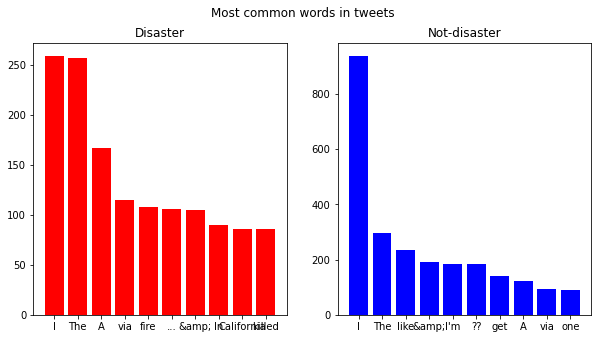

In [7]:
stop = set(stopwords.words('english'))

disaster_words = [word for tweet in df[df['target'] == 1]['text'].str.split() for word in tweet if word not in stop and word not in punctuation]
dis_cnt = Counter(disaster_words).most_common(10)
dis_cnt_x, dis_cnt_y=zip(*dis_cnt)
print(dis_cnt)

nondisaster_words = [word for tweet in df[df['target'] == 0]['text'].str.split() for word in tweet if word not in stop  and word not in punctuation]
nondis_cnt = Counter(nondisaster_words).most_common(10)
nondis_cnt_x, nondis_cnt_y=zip(*nondis_cnt)
print(nondis_cnt)

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.bar(dis_cnt_x, dis_cnt_y, color='red')
ax1.set_title('Disaster')

ax2.bar(nondis_cnt_x, nondis_cnt_y, color='blue')
ax2.set_title('Not-disaster')

figure.suptitle('Most common words in tweets')

Cleanup is needed!

In [8]:
warnings.filterwarnings('default')

## Data preprocessing

### Creating Functions to Clean Data

#### Remove URLS

In [9]:
def remove_URL(text):
    return re.sub(r'https?://\S+|www\.\S+', r'',text)

print(remove_URL('Testing https://www.google.com'))


Testing 


#### Remove punctuation

In [10]:
def remove_punctuation(text):
    table=str.maketrans('','', punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punctuation(example))


I am a king


#### Remove Emojis

In [11]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text) # no emoji

print(remove_emojis("Testing 😀"))

Testing 


#### Spellcheck Text

In [12]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spelling(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    # if misspelled_words: print('misspelled: ', misspelled_words)
    # if misspelled_words: print('corrected: ', end='')
    for word in text.split():
        if word in misspelled_words:
            corrected_word = spell.correction(word)
            # if misspelled_words: print(corrected_word, end='')
            corrected_text.append(corrected_word)
        else:
            corrected_text.append(word)
    # if misspelled_words: print()
    return " ".join(corrected_text)
       
print("This is a test: ", correct_spelling("Corect wrod speling"))

This is a test:  Corect word spelling


#### Remove Words Containing Numbers

In [13]:
def remove_words_containing_nums(text):
    return re.sub(r'\w*\d\w*', '', text)

#### Stem Words

In [14]:
stemmer = SnowballStemmer("english")

def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

#### Lematize Words

In [15]:
lemmatizer = WordNetLemmatizer()

def lematize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

#### Remove Stopwords

In [16]:
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop])

### Cleaning Data

In [17]:
def clean_text(text):
    text = text.lower()
    text = remove_URL(text)
    text = remove_punctuation(text)
    text = remove_emojis(text)
    text = remove_words_containing_nums(text)
    # text = correct_spelling(text)
    # text = stem_text(text)
    text = lematize_text(text)
    text = remove_stopwords(text)
    return text

df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
test_df['clean_text'] = test_df['text'].apply(lambda x: clean_text(x))
df['clean_text']

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    ariaahrary thetawniest control wild fire calif...
7610                                       volcano hawaii
7611    police investigating ebike collided car little...
7612    latest home razed northern california wildfire...
Name: clean_text, Length: 7613, dtype: object

## Training Models

### XGBoost - Gradient Boosted Decision Trees

d:\Uni\Masters\Natural language processing\Project\NLPDisasterTweets\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


5709 5709
1904 1904
Train: 0.9485023646873357
Test: 0.7673319327731093


<AxesSubplot:>

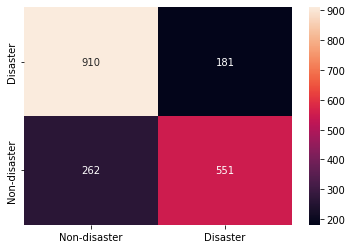

In [18]:
x = df['clean_text']
y = df['target']

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost import XGBClassifier
from sklearn import metrics

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', XGBClassifier(
        learning_rate=0.1,
        max_depth=10,
        n_estimators=1000,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

# Fit the pipeline with the data
pipe.fit(X_train, y_train)

y_pred_class = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

cm = metrics.confusion_matrix(y_test, y_pred_class)
seaborn.heatmap(cm, xticklabels=['Non-disaster', 'Disaster'], yticklabels=['Disaster', 'Non-disaster'], annot=True, fmt='d')

### Keras - GloVe + LSTM Model

#### GloVe

In [33]:
train_tweets = df['clean_text'].values
train_target = df['target'].values
test_tweets = test_df['clean_text'].values

In [72]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          Dropout,
                          SpatialDropout1D,
                          Bidirectional,
                          GlobalMaxPool1D)
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ivayl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
word_tokenizer = Tokenizer()
# Create the vocabulary index based on word frequency
word_tokenizer.fit_on_texts(train_tweets)

# Calculate the length of our vocabulary
vocab_length = len(word_tokenizer.word_index) + 1

15245

In [22]:
# Transforms each text in texts to a sequence of integers:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

In [23]:
# Find the longest sequence
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_longest_sentence = len(word_tokenize(longest_train))

# pad all sequences to the same length
train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_longest_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_longest_sentence,
    padding='post'
)

train_padded_sentences

array([[3944,  445,  155, ...,    0,    0,    0],
       [ 108,    2,  148, ...,    0,    0,    0],
       [1506, 1380, 1854, ...,    0,    0,    0],
       ...,
       [ 438, 1368,    0, ...,    0,    0,    0],
       [  22,  977, 2795, ...,    0,    0,    0],
       [ 130,   24,  444, ...,    0,    0,    0]])

In [24]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('./input/glove.6B.100d.txt', encoding="utf8") as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector

# embeddings_dictionary

In [25]:
# Create the embedding matrix where words are substituted for embeddings from GloVe
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.51124001,  0.58787   ,  0.89849001, ..., -0.49353999,
        -0.12878001, -0.45763999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.25161999,  0.73246998,  0.30792999, ..., -0.89315999,
         1.29760003, -0.04898   ],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

#### LSTM Model

In [26]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [56]:
print(length_longest_sentence)

23


In [76]:
model = Sequential(name = 'LSTM_model')

model.add(Embedding(
    input_dim = embedding_matrix.shape[0], 
    output_dim = embedding_matrix.shape[1], 
    weights = [embedding_matrix], 
    input_length = length_longest_sentence
))

model.add(Bidirectional(LSTM(
    length_longest_sentence, 
    return_sequences = True, 
    recurrent_dropout = 0.2
)))

model.add(SpatialDropout1D(0.2))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(length_longest_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

history = model.fit(
    X_train,
    y_train,
    epochs = 10,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/10
177/179 [============================>.] - ETA: 0s - loss: 0.8148 - accuracy: 0.6001
Epoch 1: val_loss improved from inf to 0.57286, saving model to model.h5
179/179 [==============================] - 6s 20ms/step - loss: 0.8132 - accuracy: 0.6015 - val_loss: 0.5729 - val_accuracy: 0.7253
Epoch 2/10
178/179 [============================>.] - ETA: 0s - loss: 0.5754 - accuracy: 0.7277
Epoch 2: val_loss improved from 0.57286 to 0.48353, saving model to model.h5
179/179 [==============================] - 3s 19ms/step - loss: 0.5758 - accuracy: 0.7273 - val_loss: 0.4835 - val_accuracy: 0.7831
Epoch 3/10
177/179 [============================>.] - ETA: 0s - loss: 0.5059 - accuracy: 0.7735
Epoch 3: val_loss improved from 0.48353 to 0.44502, saving model to model.h5
179/179 [==============================] - 3s 19ms/step - loss: 0.5068 - accuracy: 0.7735 - val_loss: 0.4450 - val_accuracy: 0.8015
Epoch 4/10
178/179 [============================>.] - ETA: 0s - loss: 0.4644 - accuracy: 

Text(0.5, 1.0, 'accuracy and val_accuracy')

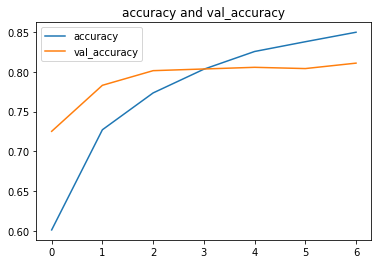

In [79]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy and val_accuracy')

In [80]:
y_pred = (model.predict(X_test) > 0.5).astype('int32')

print(classification_report(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1115
           1       0.76      0.80      0.78       789

    accuracy                           0.81      1904
   macro avg       0.80      0.81      0.81      1904
weighted avg       0.81      0.81      0.81      1904

0.8109243697478992
